The New York Times Crossword offers a shockingly addicting feature that many of you may very well be familiar with -- the "Daily Mini." This crossword puzzle is the morning sport found in many-an-office, and (at least for me) has often sparked heated competition that, admittedly, sometimes goes a bit too far.
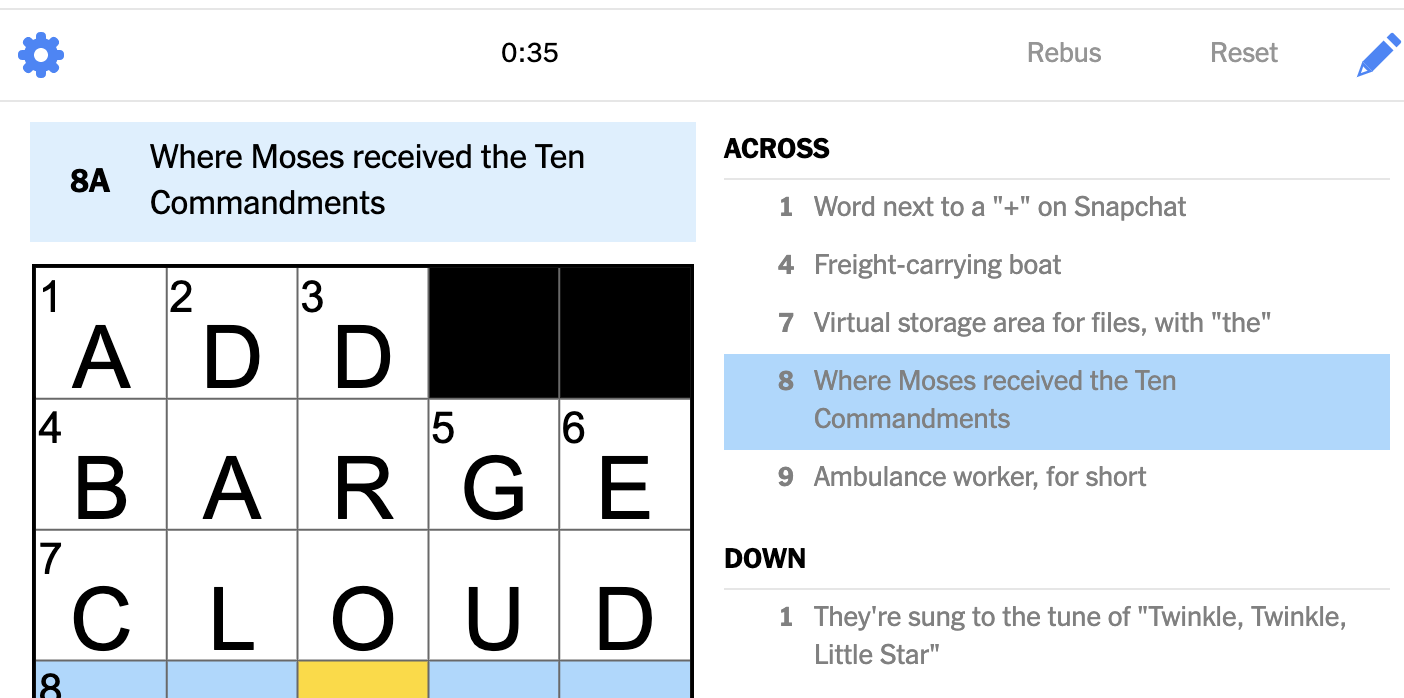

For an experienced puzzler a typical mini usually takes less than 60 seconds, with the exception of the Saturday puzzle which is roughly twice the size of the standard minis. My girlfriend and I have fallen into the habit of saving our times and smugly messaging them to each other when we feel confident our speed can't be beat. Unfortunately this often leads to me sending self-satisfied screenshots that receive prompt replies from her completing the same puzzle seconds faster. Truly I shall never learn. Recently though we've wondered, which of us is truly faster? And by how much?

To quantify this, I wrote a simply python script to scrape the NYT crossword puzzle page and, using her and my login info separately, I was able to pull down a list of 350 times (175 data points each), on dates where we both completed the mini. My goal is to analyze the data and clarify the confidence interval arround the bootstrap distribution of our average time difference and proclaim, once and for all, who is faster (_she is_), and by how much (TBD!)

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [144]:
times = pd.read_csv('rose.csv')

In [145]:
times.head()

,mins,colon,tens,ones,date,rwp,jet,diff
0,1,:,0,5,8/1/19,65,54,11
1,0,:,4,3,7/31/19,43,42,1
2,0,:,4,1,7/30/19,41,43,-2
3,0,:,2,9,7/29/19,29,26,3
4,0,:,3,8,7/28/19,38,151,-113


Here we can quickly examine what the dataset looks like. I'm no web-scraping expert, so I had my script clunkily parse the timeer-count tag and separate the minute and second values. From there I could convert those times into seconds and merge the two lists together to obtain a column for my times and her times, as well as calculate the difference between us on any given day.

In [148]:
#clean_times = times.query('jet <= 60 and rwp <= 60')
clean_times = times
time_diffs = pd.melt(clean_times, id_vars=['date'], 
                value_vars=['rwp', 'jet'],
                var_name = 'identity',
                value_name = 'time'
            )
time_diffs.head()

,date,identity,time
0,8/1/19,rwp,65
1,7/31/19,rwp,43
2,7/30/19,rwp,41
3,7/29/19,rwp,29
4,7/28/19,rwp,38


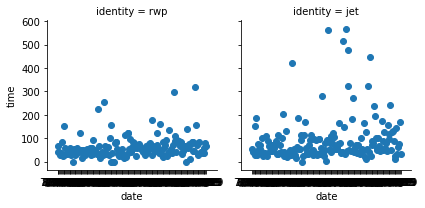

In [149]:
g = sns.FacetGrid(time_diffs, col='identity')
g = g.map(plt.scatter, 'date', 'time')

One thing that seems noticeable up front is my times seem to show higher variance than hers; to be fair I have a bad habit of letting the clock run indefinitely when I'm not sure how to solve certain puzzles.

In [150]:
time_diffs.groupby('identity').agg(['mean', 'max', 'min', 'std'])

time                    
               mean  max min        std
identity                               
jet       90.131429  568   0  96.303041
rwp       61.097143  320   0  45.835246

Interestingly enough it looks like certain puzzles have solve times of 0? This is likely due to either of us just not doing a puzzle on a given day. We should remove these times from the data before moving forward.

In [160]:
t2 = time_diffs[time_diffs['time'] > 13]
t2.groupby('identity').agg(['mean', 'max', 'min', 'std'])

time                    
               mean  max min        std
identity                               
jet       92.081871  568  15  96.561680
rwp       63.189349  320  15  45.239702

The next decision to make is how to handle the high outliers (+3 minute solves). As a longtime crossword puzzler it's a fairly accepted rule that weekday puzzles are doable in under a minute, Saturday puzzles in under 3 minutes, on average. The data points on both of our plots beyond 200 seconds are more likely to be (a) leaving the puzzle running on my computer and stopping part way through to answer an email and letting the clock run and forgetting about it or (b) being unusually tired, sick, or otherwise mentally impaired while doing it than (c) true representations of either her or my actual puzzle-completion-ability. Therefore, since we are interested in answering the question of which of us is the better puzzler, assuming normal-to-good puzzling conditions, it seems reasonable to trim this data to exluce the higher outliers. This will decrease the overall mean and standard deviations for both of our stats and should yield a result that will be a better estimate for the true difference in her and my solve times. To choose a threshold of where should select this cutoff point we can plot the data once more.

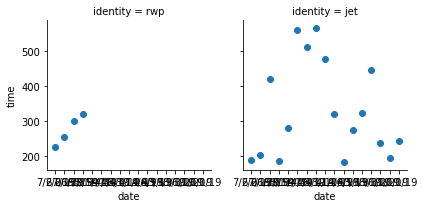

In [167]:
g = sns.FacetGrid(t2[t2['time'] > 180], col='identity')
g = g.map(plt.scatter, 'date', 'time')

Looking only at puzzles that took either of us more than 3 minutes, it's embarassingly clear that I'm a lot sloppier than Rose. It would definitely help me a lot more than her to trim these samples and make it even harder to prove that she's the faster puzzler. Well, if we're gonna do this I'll need all the help I can get, so let's go ahead and trim these high times (chalk it up to me "caring less" about my averages than she does and being more willing to let the clock run up than she.)

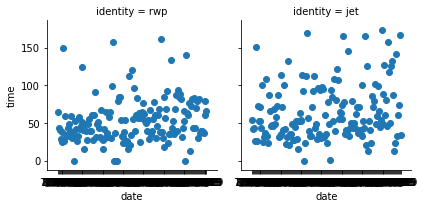

In [174]:
clean_times = times.query('jet <= 180 and rwp <= 180')
t3 = pd.melt(clean_times, id_vars=['date'], 
                value_vars=['rwp', 'jet'],
                var_name = 'identity',
                value_name = 'time'
            )

g = sns.FacetGrid(t3, col='identity')
g = g.map(plt.scatter, 'date', 'time')

Boom. Now are scatter plots are much less distinct than the initial plot. Looking at this, it's not super obvious there's a difference in performance.

In [175]:
t3.groupby('identity').agg('mean')

,time
identity,
jet,64.089172
rwp,52.808917


In [176]:
t3.shape

(314, 3)

According to this data Rose is still ~11.3 seconds faster than me on average. But how confident should we be in that guess of 11.3 seconds? After all we are after the cold hard truth and we only have 314 samples (157 points each). It's somewhere on the spectrum of a completely worthless guess and the exact truth. The beauty of statistics is it let's us quantify which _part_ of the grey zone we're in so we can actually derive a reasonable interval. Instead of 11.3 seconds we could say that we're _positive beyond all doubt_ that the true difference is bewtween -infinity and +infinity. We may even say we're very confident it's between (-10 , 30) seconds (since our best guess was -11.3, if we tack on 20 above and 20 below we could say very confident. Well, based on what? There's really nothing to back that claim up but it sounds vaguely reasonable.  What if instead we used the idea of confidence intervals and we said that we are exactly 95% confident -- not just "very" confident let's give it a number -- we're 95% that the true difference in our solve times are between two values. The next step then, is to actually calculate our predicted interval that is 95% likely to contain the true difference. Note that we can find an interval for _any_ degree of confident (90%, 99%, but 95% is the usual standard practice.

Remember: the goal is to find how precise our guess (-11.3) really is by imagining what _other_ guesses could look like. Now our guess was -11.3 seconds, but let's imagine that I scraped a different date range of data, or I went farther back in time, or not as far back in time and collected thousands upon thousands of data points comparing Rose's to my times. If all our our guesses are really close to -11.3 every time we took a new (theoretical) sample of crossword solve times, then we can make a pretty small interval. However if I supposedly went back in time and gathered more data and collected some guesses that said _I_ was faster than Rose (gasp!), or she was faster by 20 seconds (double gasp), then our confidence interval would as a result be wider (more uncertainty given the variance of the different samples). The problem is that I can only collect so many data points; alas, I only got the puzzle subscription a year ago and as much as I hate to admit it, I don't complete the puzzle every day and nor does she. This limits the number of _available_ usable data points that we have on-hand to answer our question. What we _can_ do is use a little cheater technique called the bootstrap.

### The Bootstrap

The basic idea behind the bootstrap assumes that the sample data is collected randomly and that the solve times I collected are a true and fair representation of our true performance ability (i.e. I didn't cherry pick data points on days I knew I did well, apart from some light outlier exclusion I plugged in a data range and pulled down points within the desired range). Our next step is to take our original sample of 314 data points and make thousands of copies of it, leaving us with a huge sample of potential solve times with the exact same mean and variance as the original data, just many times larger. Then we will pretend that our sample, after we multiply it over and over and over again, is the full set of rose and my crossword solving times. Now, that seems like a little bit of a logical jump, and it is! But, what other information do we have? The information we have from our 1 sample is our best guess we have of the true difference in solve times. So it's not unreasonable to take our sample data and copy and paste it over and over to call it our population of solve times. The reason this is called the bootstrap method is that we then sample 314 points from the pool of cloned data to create what we called a "bootstrapped sample." This sample will have a slightly different mean solve time for Rose and I than the original data. This allows us to compile thousands of different resample data sets of solve times quickly and efficiently, without having to scrape more data from the web. Let's take a look at what this might look like in practice.

In [177]:
t3.groupby('identity').agg('mean')

,time
identity,
jet,64.089172
rwp,52.808917


In [178]:
t3.groupby('identity').agg('max')

,date,time
identity,,
jet,8/1/19,174
rwp,8/1/19,162


In [179]:
t3.shape

(314, 3)

In [180]:
n = 72
sample1 = time_diffs.query('identity == "rwp"').iloc[np.random.randint(n, size=n)]
sample2 = time_diffs.query('identity == "jet"').iloc[np.random.randint(n, size = n)]

In [181]:
sample1.time.mean()

55.416666666666664

In [182]:
sample2.time.mean()

82.93055555555556

In [216]:
samp_date = time_diffs.date.iloc[np.random.randint(n, size = 1)].to_string()
samp_date 

'61    6/1/19'

In [207]:
time_diffs.query('date = samp_date')

ValueError: cannot assign without a target object

pandas.core.series.Series

In these two single samples of rose's times and my times, she ended up with a mean of 55 (compared to 52 in the original data) and I ended up with 82 (compared to 64 in the original data). Let's see what happens if we repeat this process 10,000 times.

In [191]:
mean_diffs = []
n = 72
for i in range(0,10000):
    samp_date = time_diffs.date.iloc[np.random.randint(n, size = 1)]
    r_samp = time_diffs.query('identity == "rwp"').time.iloc[np.random.randint(n, size=n)]
    j_samp = time_diffs.query('identity == "jet"').time.iloc[np.random.randint(n, size = n)]
    
    time_diff = r_samp.mean() - j_samp.mean()
    mean_diffs.append(time_diff)

(array([6.0000e+00, 7.0000e+01, 9.2500e+02, 5.8920e+03, 2.1030e+04,
        3.6139e+04, 2.7043e+04, 8.0200e+03, 8.4500e+02, 3.0000e+01]),
 array([-60.45833333, -52.30972222, -44.16111111, -36.0125    ,
        -27.86388889, -19.71527778, -11.56666667,  -3.41805556,
          4.73055556,  12.87916667,  21.02777778]),
 <a list of 10 Patch objects>)

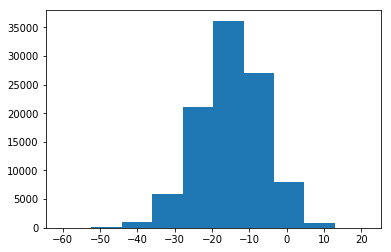

In [192]:
plt.hist(mean_diffs)

The mean differences will be a little bit different but they should in general tend towards the middle. Sure enough, the peak of this histogram is centered at -14.7, roughly around our "best guess of -11.3. But we also see this weird trailing off effect where certain guesses could be a little bit lower or a little bit higher -- this gives us a range of confidence that lets us say that the middle 95% of our guesses fall between values (a,b). 

In [193]:
sum(mean_diffs)/len(mean_diffs)

-14.843089166666507

Next we can calculate the percentiles of our mean differences to find the coveted 95% confidence interval and settle the score once and for all.

In [210]:
np.percentile(mean_diffs, 97.5)

1.4583333333333357

In [212]:
np.percentile(mean_diffs, 2.5)

-32.41701388888889

This confidence interval says with 95% confidence that the true difference is between rose being 47 seconds faster and jane being 1.5 seconds faster.

We could also say with 96% confidence that Rose is faster than Jane

In [211]:
np.percentile(mean_diffs, 95)

-1.05555555555555